# **2.1 Transformer Architectures for Transaction Logs**

In [ ]:
!pip install torch pandas numpy matplotlib scikit-learn --quiet
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("/content/MyTransaction.csv", low_memory=False)

df = df.dropna(how="all").reset_index(drop=True)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

df["amount"] = df["Deposit"].fillna(0) - df["Withdrawal"].fillna(0)
df["log_amount"] = np.log1p(np.abs(df["amount"]))

df["time_gap"] = df["Date"].diff().dt.days.fillna(0)

df["category_code"] = df["Category"].astype("category").cat.codes
NUM_CATEGORIES = df["category_code"].nunique()


In [ ]:
numeric_features = df[["log_amount", "time_gap"]].fillna(0)

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_features)


In [ ]:
SEQ_LEN = 50

num_seqs = []
cat_seqs = []

for i in range(len(df) - SEQ_LEN):
    num_seqs.append(numeric_scaled[i:i+SEQ_LEN])
    cat_seqs.append(df["category_code"].iloc[i:i+SEQ_LEN].values)

X_num = torch.tensor(num_seqs, dtype=torch.float32)
X_cat = torch.tensor(cat_seqs, dtype=torch.long)

dataset = TensorDataset(
    X_num[:, :-1],
    X_cat[:, :-1],
    X_num[:, 1:],
    X_cat[:, 1:]
)

loader = DataLoader(dataset, batch_size=32, shuffle=True)


/tmp/ipython-input-3982653417.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X_num = torch.tensor(num_seqs, dtype=torch.float32)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [ ]:
def causal_mask(seq_len):
    return torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()


In [ ]:
class TransactionTransformer(nn.Module):
    def __init__(self, num_categories, d_model=64, nhead=4, num_layers=3):
        super().__init__()

        self.numeric_embed = nn.Linear(2, d_model)
        self.category_embed = nn.Embedding(num_categories, d_model)

        self.positional = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.numeric_head = nn.Linear(d_model, 2)
        self.category_head = nn.Linear(d_model, num_categories)

    def forward(self, x_num, x_cat):
        num_emb = self.numeric_embed(x_num)
        cat_emb = self.category_embed(x_cat)

        x = num_emb + cat_emb
        x = self.positional(x)

        mask = causal_mask(x.size(1)).to(x.device)
        x = self.transformer(x, mask)

        return self.numeric_head(x), self.category_head(x)


In [ ]:
model = TransactionTransformer(NUM_CATEGORIES)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

loss_num = nn.MSELoss()
loss_cat = nn.CrossEntropyLoss()

EPOCHS = 500

for epoch in range(EPOCHS):
    total_loss = 0

    for xn, xc, yn, yc in loader:
        pn, pc = model(xn, xc)

        l_num = loss_num(pn, yn)
        l_cat = loss_cat(pc.reshape(-1, NUM_CATEGORIES), yc.reshape(-1))

        loss = l_num + 0.5 * l_cat

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 10 | Loss: 49.3545
Epoch 20 | Loss: 38.5435
Epoch 30 | Loss: 33.2797
Epoch 40 | Loss: 27.1897
Epoch 50 | Loss: 22.5785
Epoch 60 | Loss: 17.9628
Epoch 70 | Loss: 15.1895
Epoch 80 | Loss: 12.9946
Epoch 90 | Loss: 11.3429
Epoch 100 | Loss: 10.3730
Epoch 110 | Loss: 9.3953
Epoch 120 | Loss: 9.1369
Epoch 130 | Loss: 8.5457
Epoch 140 | Loss: 7.8276
Epoch 150 | Loss: 7.2119
Epoch 160 | Loss: 6.9787
Epoch 170 | Loss: 6.9800
Epoch 180 | Loss: 6.3614
Epoch 190 | Loss: 6.0954
Epoch 200 | Loss: 5.5842
Epoch 210 | Loss: 5.9597
Epoch 220 | Loss: 5.1847
Epoch 230 | Loss: 5.5387
Epoch 240 | Loss: 5.1832
Epoch 250 | Loss: 4.8038
Epoch 260 | Loss: 5.3557
Epoch 270 | Loss: 4.7494
Epoch 280 | Loss: 4.5316
Epoch 290 | Loss: 4.6172
Epoch 300 | Loss: 4.5331
Epoch 310 | Loss: 4.1377
Epoch 320 | Loss: 4.8640
Epoch 330 | Loss: 4.2293
Epoch 340 | Loss: 4.1782
Epoch 350 | Loss: 4.0084
Epoch 360 | Loss: 4.4202
Epoch 370 | Loss: 4.0265
Epoch 380 | Loss: 3.8371
Epoch 390 | Loss: 3.9677
Epoch 400 | Loss: 3.7690

In [ ]:
model.eval()
errors = []

with torch.no_grad():
    for xn, xc, yn, yc in loader:
        pn, _ = model(xn, xc)
        err = torch.mean((pn - yn) ** 2, dim=(1,2))
        errors.extend(err.numpy())

errors = np.array(errors)
threshold = np.percentile(errors, 95)

print("Anomaly Threshold:", threshold)


Anomaly Threshold: 0.08154437


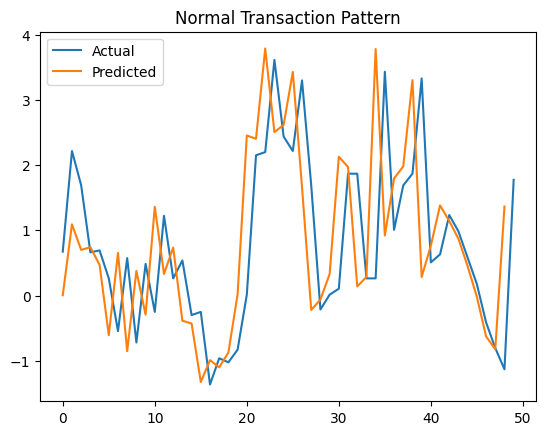

In [ ]:
sample_num = X_num[-1:].clone()
sample_cat = X_cat[-1:].clone()

with torch.no_grad():
    pred_num, _ = model(sample_num[:, :-1], sample_cat[:, :-1])

plt.plot(sample_num[0,:,0].numpy(), label="Actual")
plt.plot(pred_num[0,:,0].numpy(), label="Predicted")
plt.legend()
plt.title("Normal Transaction Pattern")
plt.show()


In [ ]:
fraud_num = sample_num.clone()
fraud_cat = sample_cat.clone()

fraud_num[0, -1, 0] += 4        # sudden huge spend
fraud_cat[0, -1] = (fraud_cat[0, -1] + 7) % NUM_CATEGORIES

with torch.no_grad():
    fraud_pred, _ = model(fraud_num[:, :-1], fraud_cat[:, :-1])

fraud_score = torch.mean((fraud_pred - fraud_num[:, 1:])**2).item()

print("Fraud Score:", fraud_score)
print("Is Fraud:", fraud_score > threshold)


Fraud Score: 0.2670319378376007
Is Fraud: True


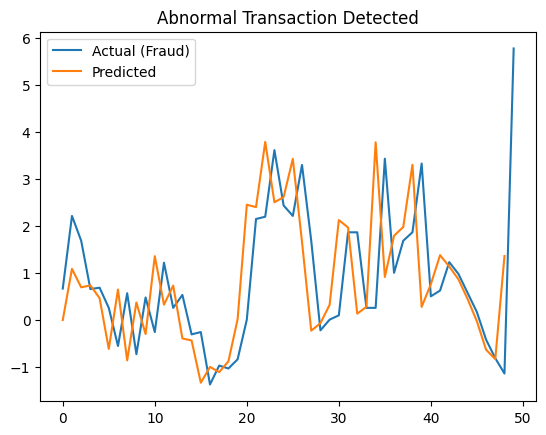

In [ ]:
plt.plot(fraud_num[0,:,0].numpy(), label="Actual (Fraud)")
plt.plot(fraud_pred[0,:,0].numpy(), label="Predicted")
plt.legend()
plt.title("Abnormal Transaction Detected")
plt.show()


# **2.2 Pretrained Financial Embeddings**

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("/content/MyTransaction.csv")

df["Date"] = pd.to_datetime(
    df["Date"],
    dayfirst=True,
    errors="coerce"
)
df = df.sort_values("Date").reset_index(drop=True)
df = df.dropna(subset=["Date"]).reset_index(drop=True)

# Amount logic
df["amount"] = df["Deposit"].fillna(0) - df["Withdrawal"].fillna(0)
df["log_amount"] = np.log1p(np.abs(df["amount"]))

# Time gap
df["time_gap"] = df["Date"].diff().dt.days.fillna(0)

# Category encoding
df["category_code"] = df["Category"].astype("category").cat.codes
NUM_CATEGORIES = df["category_code"].nunique()

# Frequency (how often user transacts in this category)
df["frequency"] = df.groupby("Category").cumcount() + 1

# Numerical + categorical split
num_features = ["log_amount", "time_gap", "Balance", "frequency"]
cat_features = ["category_code"]

scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])


In [ ]:
X_num = torch.tensor(df[num_features].values, dtype=torch.float32)
X_cat = torch.tensor(df[cat_features].values, dtype=torch.long)

In [ ]:
class FinancialTabTransformer(nn.Module):
    def __init__(self, num_numeric, num_categories, d_model=128, nhead=4):
        super().__init__()

        # Numeric feature embeddings
        self.num_embed = nn.ModuleList([
            nn.Linear(1, d_model) for _ in range(num_numeric)
        ])

        # Categorical embeddings
        self.cat_embed = nn.Embedding(num_categories, d_model)

        # Column identity embeddings
        self.col_embed = nn.Embedding(num_numeric + 1, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.reconstruct = nn.Linear(d_model, 1)

    def forward(self, x_num, x_cat, mask=None):
        batch_size = x_num.size(0)
        embeddings = []

        # Numeric columns
        for i, layer in enumerate(self.num_embed):
            e = layer(x_num[:, i:i+1])
            e += self.col_embed(torch.tensor(i))
            embeddings.append(e)

        # Categorical column
        cat_e = self.cat_embed(x_cat.squeeze())
        cat_e += self.col_embed(torch.tensor(len(self.num_embed)))
        embeddings.append(cat_e)

        x = torch.stack(embeddings, dim=1)

        if mask is not None:
            x = x.masked_fill(mask.unsqueeze(-1), 0)

        z = self.transformer(x)
        recon = self.reconstruct(z).squeeze(-1)

        # Row-level financial embedding
        return recon, z.mean(dim=1)


In [ ]:
def mask_features(x_num, x_cat, ratio=0.3):
    num_mask = torch.rand(x_num.shape) < ratio
    cat_mask = torch.rand(x_cat.shape) < ratio
    return num_mask, cat_mask

In [ ]:
model = FinancialTabTransformer(
    num_numeric=X_num.shape[1],
    num_categories=NUM_CATEGORIES
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(500):
    num_mask, cat_mask = mask_features(X_num, X_cat)

    x_num_masked = X_num.clone()
    x_cat_masked = X_cat.clone()

    x_num_masked[num_mask] = 0
    x_cat_masked[cat_mask] = 0

    recon, embedding = model(x_num_masked, x_cat_masked)

    recon_num = recon[:, :X_num.shape[1]]

    loss = loss_fn(
        recon_num[num_mask],
        X_num[num_mask]
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 1.5062
Epoch 10 | Loss: 1.3775
Epoch 20 | Loss: 1.0235
Epoch 30 | Loss: 0.9905
Epoch 40 | Loss: 1.1777
Epoch 50 | Loss: 0.8356
Epoch 60 | Loss: 1.1008
Epoch 70 | Loss: 0.8992
Epoch 80 | Loss: 0.9470
Epoch 90 | Loss: 0.7397
Epoch 100 | Loss: 1.0133
Epoch 110 | Loss: 0.7215
Epoch 120 | Loss: 0.9341
Epoch 130 | Loss: 0.9115
Epoch 140 | Loss: 0.6922
Epoch 150 | Loss: 0.8598
Epoch 160 | Loss: 0.8614
Epoch 170 | Loss: 0.7337
Epoch 180 | Loss: 0.7993
Epoch 190 | Loss: 0.7657
Epoch 200 | Loss: 1.0063
Epoch 210 | Loss: 0.7654
Epoch 220 | Loss: 0.8841
Epoch 230 | Loss: 0.8501
Epoch 240 | Loss: 0.8477
Epoch 250 | Loss: 1.1066
Epoch 260 | Loss: 0.8540
Epoch 270 | Loss: 0.6626
Epoch 280 | Loss: 0.9282
Epoch 290 | Loss: 1.1912
Epoch 300 | Loss: 0.8218
Epoch 310 | Loss: 0.7840
Epoch 320 | Loss: 1.1440
Epoch 330 | Loss: 0.9185
Epoch 340 | Loss: 0.9374
Epoch 350 | Loss: 1.0504
Epoch 360 | Loss: 0.9926
Epoch 370 | Loss: 0.6876
Epoch 380 | Loss: 0.7749
Epoch 390 | Loss: 0.6944
Epoch 400 |

In [ ]:
_, financial_embedding = model(X_num[:5], X_cat[:5])
print(financial_embedding.shape)

torch.Size([5, 128])


# **2.3 Cross-Industry Temporal Foundation Models**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def generate_industry_data(scale, gap, freq, num_seq=200, seq_len=12):
    data = []
    for _ in range(num_seq):
        seq = np.zeros((seq_len, 4))
        seq[:, 0] = np.random.randn(seq_len) * scale          # event_value
        seq[:, 1] = np.random.randint(0, 5, seq_len)          # event_type
        seq[:, 2] = np.abs(np.random.randn(seq_len)) + gap    # time_delta
        seq[:, 3] = freq                                      # event_frequency
        data.append(seq)
    return torch.tensor(data, dtype=torch.float32)

In [ ]:
bank_data = generate_industry_data(scale=1.0, gap=1, freq=2)
insurance_data = generate_industry_data(scale=3.0, gap=7, freq=0.5)
retail_data = generate_industry_data(scale=0.3, gap=0.5, freq=5)

all_data = torch.cat([bank_data, insurance_data, retail_data])

/tmp/ipython-input-4283915948.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(data, dtype=torch.float32)


In [ ]:
class TemporalFoundationModel(nn.Module):
    def __init__(self, input_dim=4, d_model=128, nhead=4, layers=3):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=layers
        )

    def forward(self, x):
        x = self.input_proj(x)
        z = self.encoder(x)
        return z

In [ ]:
def mask_timesteps(x, ratio=0.3):
    mask = torch.rand(x.shape[:2]) < ratio
    x_masked = x.clone()
    x_masked[mask] = 0
    return x_masked, mask

In [ ]:
class TemporalReconstructor(nn.Module):
    def __init__(self, encoder, d_model=128, input_dim=4):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(d_model, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z), z.mean(dim=1)


In [ ]:
encoder = TemporalFoundationModel()
model = TemporalReconstructor(encoder)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(60):
    x_masked, mask = mask_timesteps(all_data)
    recon, _ = model(x_masked)

    loss = loss_fn(recon[mask], all_data[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 10.1743
Epoch 10 | Loss: 2.0473
Epoch 20 | Loss: 1.6634
Epoch 30 | Loss: 1.4702
Epoch 40 | Loss: 1.4535
Epoch 50 | Loss: 1.4004


In [ ]:
for p in encoder.parameters():
    p.requires_grad = False

In [ ]:
bank_emb = encoder(bank_data).mean(dim=1)
insurance_emb = encoder(insurance_data).mean(dim=1)
retail_emb = encoder(retail_data).mean(dim=1)


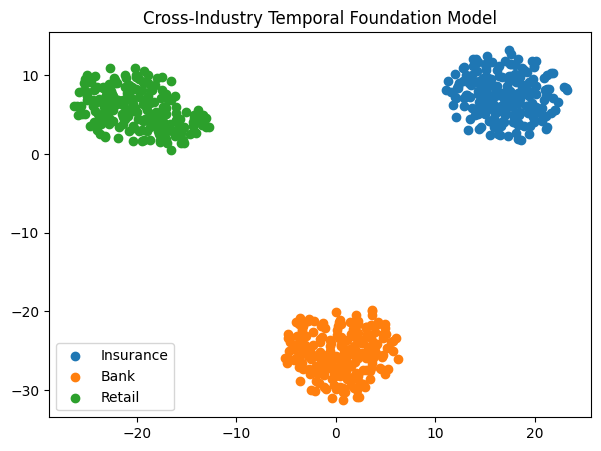

In [ ]:
embeddings = torch.cat([bank_emb, insurance_emb, retail_emb]).detach().numpy()
labels = (
    ["Bank"]*len(bank_emb) +
    ["Insurance"]*len(insurance_emb) +
    ["Retail"]*len(retail_emb)
)

tsne = TSNE(n_components=2, perplexity=30)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(7,5))
for label in set(labels):
    idx = [i for i,l in enumerate(labels) if l == label]
    plt.scatter(emb_2d[idx,0], emb_2d[idx,1], label=label)

plt.legend()
plt.title("Cross-Industry Temporal Foundation Model")
plt.show()
